In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import PIL
import time
from os import listdir
from os.path import isfile, join
import torch.nn.functional as F

from skimage import filters
from skimage import exposure
filelist = [f for f in listdir('D:/DataSet/VOC/labels') if isfile(join('D:/DataSet/VOC/labels', f))]
labels_path = 'D:/DataSet/VOC/labels/'
images_path = 'D:/DataSet/VOC/images/'
plt.rcParams["figure.figsize"] = (12,8)
res = models.resnet101(pretrained=True)
res

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [4]:
class _PyramidPoolingModule(nn.Module):
    def __init__(self, in_dim, reduction_dim, setting):
        super(_PyramidPoolingModule, self).__init__()
        self.features = []
        for s in setting:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(s),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim, momentum=.95),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.upsample(f(x), x_size[2:], mode='bilinear'))
        out = torch.cat(out, 1)
        return out
class PSPNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, use_aux=True):
        super(PSPNet, self).__init__()
        self.use_aux = use_aux
        resnet = models.resnet18(pretrained=True)
    
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

#         for n, m in self.layer3.named_modules():
#             if 'conv1' in n:
#                 m.stride = (1, 1)
#             elif 'downsample.0' in n:
#                 m.stride = (1, 1)
#         for n, m in self.layer4.named_modules():
#             if 'conv1' in n:
#                 m.stride = (1, 1)
#             elif 'downsample.0' in n:
#                 m.stride = (1, 1)

        self.ppm = _PyramidPoolingModule(512, 512, (1, 2, 3, 6))
        self.final = nn.Sequential(
            nn.Conv2d(2560, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

        if use_aux:
            self.aux_logits = nn.Conv2d(1024, num_classes, kernel_size=1)
            initialize_weights(self.aux_logits)

#         initialize_weights(self.ppm, self.final)

    def forward(self, x):
        x_size = x.size()
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if self.training and self.use_aux:
            aux = self.aux_logits(x)
        x = self.layer4(x)
        print(x.size())
        x = self.ppm(x)
        x = self.final(x)
        if self.training and self.use_aux:
            return F.upsample(x, x_size[2:], mode='bilinear'), F.upsample(aux, x_size[2:], mode='bilinear')
        return F.upsample(x, x_size[2:], mode='bilinear')
PSP_net = PSPNet(2,True,False)
PSPNet = PSP_net.cuda()
PSP_net

PSPNet (
  (layer0): Sequential (
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  )
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [8]:
densenet = models.densenet121(pretrained=True)
densenet

DenseNet (
  (features): Sequential (
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU (inplace)
    (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock (
      (denselayer1): _DenseLayer (
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU (inplace)
        (conv.2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer (
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

torch.Size([1, 512, 19, 19])


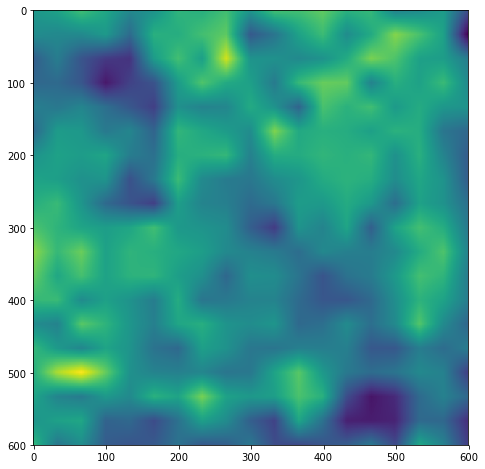

In [5]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])
test = test_transform(PIL.Image.open('style.jpg')).unsqueeze(0)
test = Variable(test.cuda())
out = PSP_net(test)
out = (out.cpu()[0].data.numpy()).transpose((1, 2, 0))
plt.imshow(out[:,:,0])
plt.show()
